# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

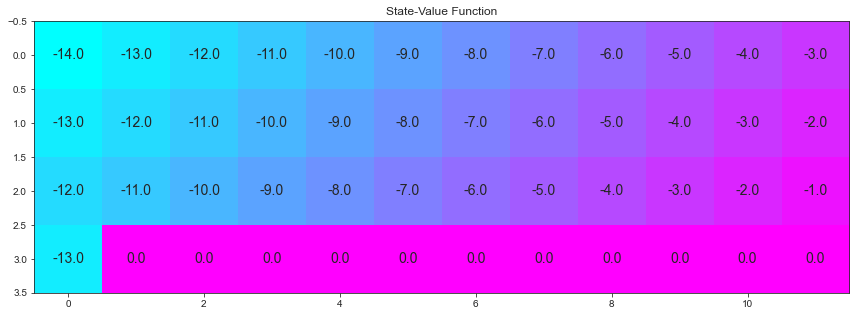

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [5]:
import random
def eps_greedy(Q, state, eps, nA):
    if random.random() > eps:
        return np.argmax(Q[state])
    else:
        return random.choice(np.arange(nA))

In [19]:
def update_Q_sarsa(Q, alpha, gamma, 
                   state, action, reward, 
                   next_state=None, next_action=None):
    Qsa = Q[state][action]
    if next_state is None or next_action is None:
        Qsa_next = 0
    else:
        Qsa_next = Q[next_state][next_action]
    target = reward + (gamma * Qsa_next)
    Qsa = Qsa + alpha * (target - Qsa)
    Q[state][action] = Qsa
    return Q

In [20]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    nA = env.nA
    # initialize performance monitor
    scores = deque(maxlen=100)
    avg_scores = deque(maxlen=num_episodes)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        score = 0
        state = env.reset()
        eps = 1.0 / i_episode
        action = eps_greedy(Q, state, eps, nA)
        while True:
            next_state, reward, done, info = env.step(action)
            score += reward
            if not done:
                next_action = eps_greedy(Q, next_state, eps, env.nA)
                Q = update_Q_sarsa(Q, alpha, gamma, state,
                                   action, reward, 
                                   next_state=next_state, 
                                   next_action=next_action)
                state = next_state
                action = next_action
            if done:
                Q = update_Q_sarsa(Q, alpha, gamma, state,
                                   action, reward)
                scores.append(score)
                break
        if i_episode % 100 == 0:
            avg_scores.append(np.mean(scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % 100)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % 100), np.max(avg_scores))    
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

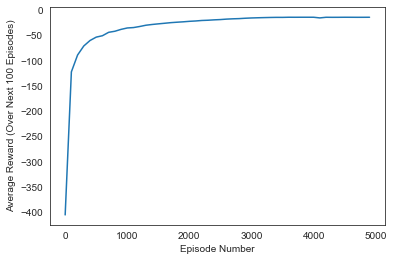

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  1  1  1  2  1  1  2  1  1  1  2]
 [ 1  2  0  0  1  1  3  2  2  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


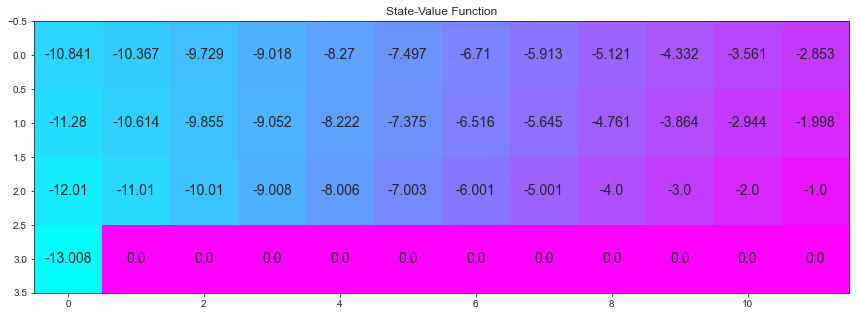

In [21]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [14]:
from __future__ import annotations
from typing import Union
from functools import reduce
import random

def eps_greedy2(
    Q_state: np.array,                
    eps: float,
    nA: int,
) -> float:
    """ Select the $\epsilon$-greedy policy, `$\pi$`
    
    Parameters
    ----------
    Q_state : np.array
        The Q-table of policies, `$\pi$` for a specific state (Q[state])
    eps : float [0, 1]
        `$\epsilon$`, percent that a random choice is selected over the greedy 
        policy
    nA : int
        Number of actions available
    """
    if random.random() > eps:
        return np.argmax(Q_state)
    else:
        return random.choice(np.arange(nA))


def update_Q_sarsamax(
    Q: defaultdict[int: np.array], 
    alpha: float,
    gamma: float,
    state: int,
    action: int,
    reward : int,
    next_state: int = None,
):
    """ Update Q-table for Q learning
    
    Parameters
    ----------
    Q : defaultdict[int: np.array]
        Q-table with Q[state][action] organization
    alpha : float 
        scaling parameter to weight previous policy values
    gamma : float
        past reward scaling
    state : int
        current state
    action : int
        planned action from state to next_state
    reward : float
        reward
    next_state : int
        next state
    """
    Qsa = Q[state][action]
    Qsa_next = np.max(Q[next_state]) if (next_state is not None) else 0
    target = reward + (gamma * Qsa_next)
    Qsa = Qsa + alpha * (target - Qsa)
    Q[state][action] = Qsa
    return Q

In [15]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    nA = env.nA
    Q = defaultdict(lambda: np.zeros(env.nA))
    scores = deque(maxlen=100)
    avg_scores = deque(maxlen=num_episodes)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        score = 0
        state = env.reset()
        eps = 1.0 / i_episode
        while True:
            action = eps_greedy2(Q[state], eps, nA)
            next_state, reward, done, info = env.step(action)
            score += reward
            Q = update_Q_sarsamax(Q, alpha, gamma, 
                                  state, action, reward,
                                  next_state)
            state = next_state

            if done:
                scores.append(score)
                break
        if i_episode % 100 == 0:
            avg_scores.append(np.mean(scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % 100)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % 100), np.max(avg_scores))            
    
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

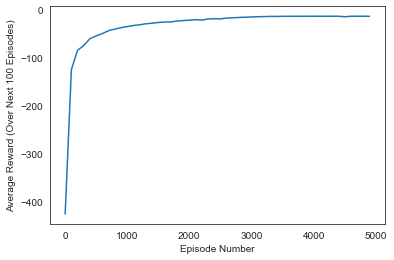

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  0  0  1  3  1  1  1  2  3  1  0]
 [ 1  2  2  1  2  2  2  1  2  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


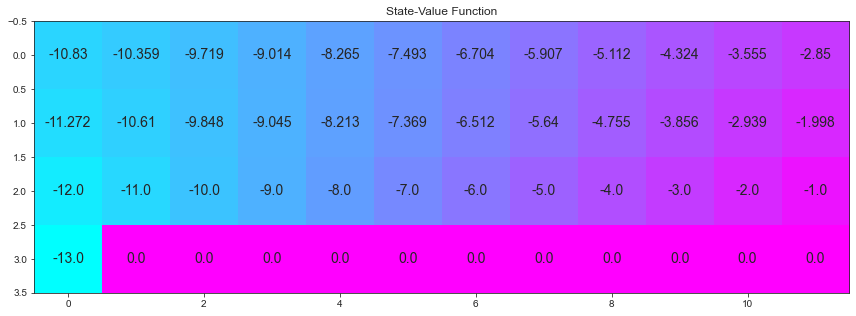

In [16]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [68]:
def update_Q_sarsaexpected(
    Q: defaultdict[int: np.array],
    alpha: float,
    gamma: float,
    eps: float,
    state: int,
    action: int,
    reward: float,
    next_state: int = None,
) -> defaultdict[int: np.array]:
    """ Update Q-table using expected sarsa
    
    Parameters
    ----------
    Q : defaultdict[int: np.array]
        Q-table with Q[state][action] organization
    alpha : float 
        scaling parameter to weight previous policy values
    gamma : float
        past reward scaling
    eps : float
        epsilon - used for evaluating expected value of the next state using
        the epsilon greedy policy ($<|\pi(a|S_{s+1})|>$, where 
        $\pi = \epsilon-greedy(Q, S, A)$)
    state : int
        current state
    action : int
        planned action from state to next_state
    reward : 
    next_state : int
        next state
    """
    Qsa = Q[state][action]
    nA = len(Q[state])
    
    policy_s = np.ones(nA) * eps / nA
    action_greed = np.argmax(Q[next_state])
    policy_s[action_greed] += (1 - eps)
    Qsa_next = np.dot(Q[next_state], policy_s)
    target = reward + (gamma * Qsa_next)
    Qsa = Qsa + alpha * (target - Qsa)
    Q[state][action] = Qsa
    return Q

In [69]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    nA = env.nA
    Q = defaultdict(lambda: np.zeros(nA))
    n_every = 100
    scores = deque(maxlen=n_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
 
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % n_every == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        score = 0
        state = env.reset()
        eps = 0.005
        while True:
            action = eps_greedy2(Q[state], eps, nA)
            next_state, reward, done, _ = env.step(action)
            score += reward
            Q = update_Q_sarsaexpected(Q, alpha, gamma, eps,
                                       state, action, reward, next_state)
            state = next_state
            if done:
                scores.append(score)
                break
        if i_episode % n_every == 0:
            avg_scores.append(np.mean(scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False),
             np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % n_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % n_every), 
          np.max(avg_scores))  
    return Q


Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000

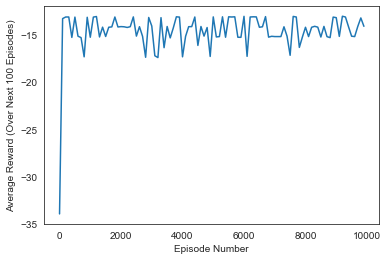

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  0  3  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


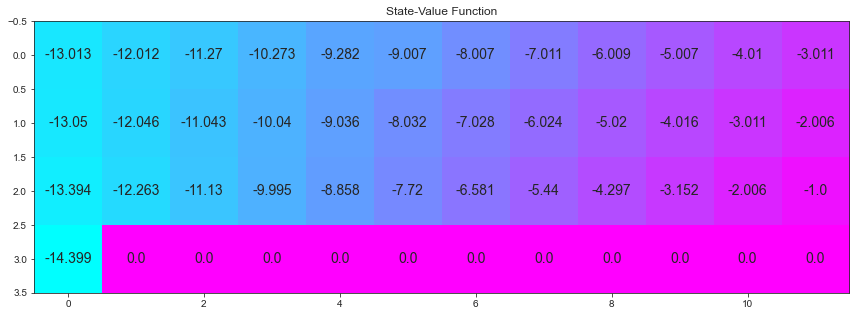

In [70]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])